In [1]:
## !pip install mlxtend
## !pip install onnxmltools
## !pip install onnxruntime
## !pip install xgboost
## !pip install onnxconverter_common
## !pip install --upgrade onnxmltools
## !pip install --upgrade onnxmltools onnxconverter_common
## !pip install skl2onnx

In [2]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score

In [4]:
import xgboost as xgb

In [5]:
import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType

In [6]:
batch_size    = 16
learning_rate = 0.001
N_Epochs      = 100

epsilon = 0.0001

In [7]:
path_data = r'C:\Users\micke\OneDrive\Documents\its 365\student-mat.csv'

stu_raw_data = pd.read_csv( path_data, delimiter=";" )

In [8]:
stu_raw_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [9]:
stu_raw_data.school = stu_raw_data.school.map( {'GP': 0, 'MS': 1})

In [10]:
stu_raw_data.sex = stu_raw_data.sex.map( {'F': 0, 'M': 1})

In [11]:
stu_raw_data.address = stu_raw_data.address.map( {'U': 0, 'R': 1})

In [12]:
stu_raw_data.famsize = stu_raw_data.famsize.map( {'LE3': 0, 'GT3': 1})

In [13]:
stu_raw_data.Pstatus = stu_raw_data.Pstatus.map( {'A': 0, 'T': 1})

In [14]:
stu_raw_data.Mjob = stu_raw_data.Mjob.map( {'at_home': 0, 'health': 1, 'other':2, 'teacher':3, 'services':4})

In [15]:
stu_raw_data.Fjob = stu_raw_data.Fjob.map( {'at_home': 0, 'health': 1, 'other':2, 'teacher':3, 'services':4})

In [16]:
stu_raw_data.reason = stu_raw_data.reason.map( {'course': 0, 'other': 1, 'home': 2, 'reputation':3})

In [17]:
stu_raw_data.guardian = stu_raw_data.guardian.map( {'mother': 0, 'father': 1, 'other': 2})

In [18]:
stu_raw_data.famsup = stu_raw_data.famsup.map( {'yes': 0, 'no': 1})

In [19]:
stu_raw_data.schoolsup = stu_raw_data.schoolsup.map( {'yes': 0, 'no': 1})

In [20]:
stu_raw_data.paid = stu_raw_data.paid.map( {'yes': 0, 'no': 1})

In [21]:
stu_raw_data.activities = stu_raw_data.activities.map( {'yes': 0, 'no': 1})

In [22]:
stu_raw_data.nursery = stu_raw_data.nursery.map( {'yes': 0, 'no': 1})

In [23]:
stu_raw_data.higher = stu_raw_data.higher.map( {'yes': 0, 'no': 1})

In [24]:
stu_raw_data.internet = stu_raw_data.internet.map( {'yes': 0, 'no': 1})

In [25]:
stu_raw_data.romantic = stu_raw_data.romantic.map( {'yes': 0, 'no': 1})

In [26]:
stu_raw_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,1,0,4,4,0,3,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,0,1,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,0,0,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,0,1,1,4,2,1,4,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,0,1,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,0,0,2,2,4,4,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,0,0,1,3,1,4,4,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,1,1,1,1,1,2,2,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,1,0,1,3,2,4,2,...,4,4,1,3,4,5,0,11,12,10


In [27]:
headers_list = stu_raw_data.columns.values.tolist()

headers_list

['school',
 'sex',
 'age',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2',
 'G3']

In [28]:
headers_list2 = [
 'age',
 'freetime', 'health', 'failures', 'absences']

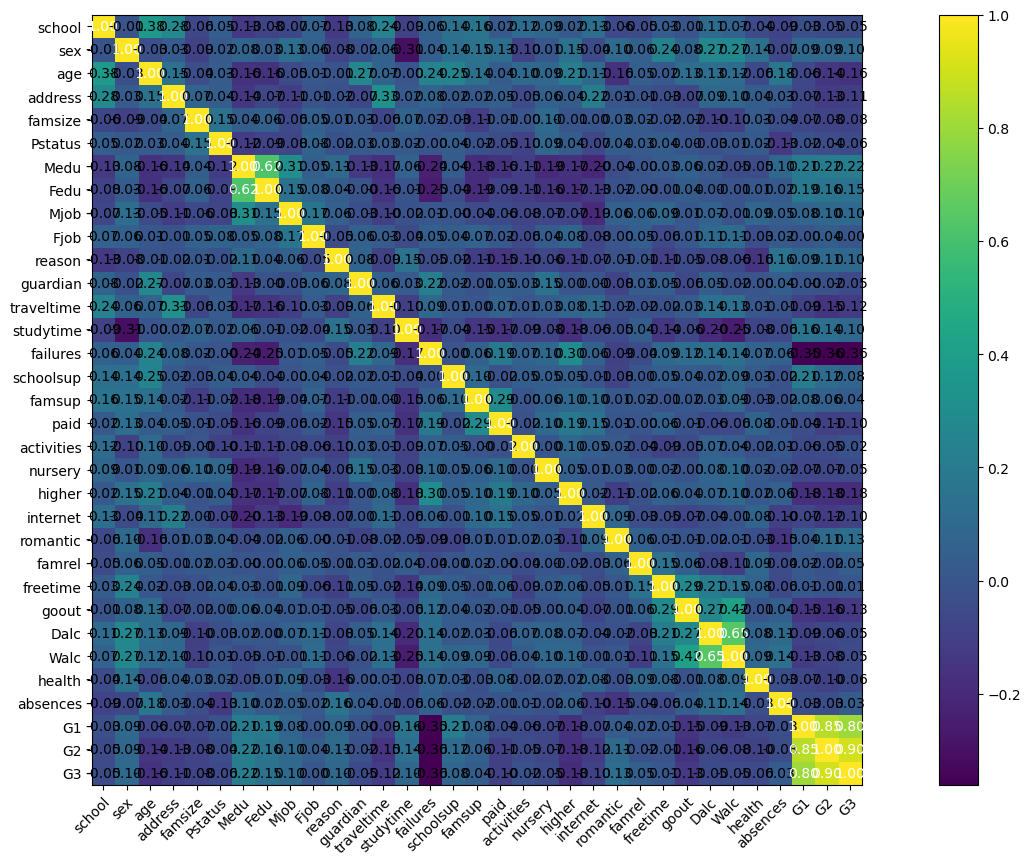

In [29]:
cm = np.corrcoef(   stu_raw_data[headers_list].values.T   )
hm = heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
plt.show()

In [30]:
## Convert Pandas to Numpy

stu_raw_data_np = stu_raw_data.to_numpy()

In [31]:

stu_raw_data_np

array([[ 0,  0, 18, ...,  5,  6,  6],
       [ 0,  0, 17, ...,  5,  5,  6],
       [ 0,  0, 15, ...,  7,  8, 10],
       ...,
       [ 1,  1, 21, ..., 10,  8,  7],
       [ 1,  1, 18, ..., 11, 12, 10],
       [ 1,  1, 19, ...,  8,  9,  9]], dtype=int64)

In [32]:
stu_raw_data_np.shape

(395, 33)

In [33]:
X = stu_raw_data_np[:, :-1]


y = stu_raw_data_np[:, 32:33]

In [34]:
y

array([[ 6],
       [ 6],
       [10],
       [15],
       [10],
       [15],
       [11],
       [ 6],
       [19],
       [15],
       [ 9],
       [12],
       [14],
       [11],
       [16],
       [14],
       [14],
       [10],
       [ 5],
       [10],
       [15],
       [15],
       [16],
       [12],
       [ 8],
       [ 8],
       [11],
       [15],
       [11],
       [11],
       [12],
       [17],
       [16],
       [12],
       [15],
       [ 6],
       [18],
       [15],
       [11],
       [13],
       [11],
       [12],
       [18],
       [11],
       [ 9],
       [ 6],
       [11],
       [20],
       [14],
       [ 7],
       [13],
       [13],
       [10],
       [11],
       [13],
       [10],
       [15],
       [15],
       [ 9],
       [16],
       [11],
       [11],
       [ 9],
       [ 9],
       [10],
       [15],
       [12],
       [ 6],
       [ 8],
       [16],
       [15],
       [10],
       [ 5],
       [14],
       [11],
       [10],
       [10],

In [35]:
print(X.shape)

print(y.shape)

(395, 32)
(395, 1)


In [36]:
random_seed = int( random.random() * 100 )     ## 42

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [38]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(316, 32)
(79, 32)
(316, 1)
(79, 1)


In [39]:
np.set_printoptions(threshold=100)  # Reset the threshold to default or any desired value
print(X_train)

[[ 0  0 16 ...  0  6  7]
 [ 0  1 17 ...  4 17 15]
 [ 0  1 16 ...  0 13 14]
 ...
 [ 0  0 16 ... 16 12 11]
 [ 1  1 18 ...  2 13 12]
 [ 0  0 19 ...  4 11 12]]


In [40]:
y_test.dtype 

dtype('int64')

In [41]:
X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )
y_train = y_train.astype(  np.float32  )
y_test  = y_test.astype(   np.float32  )

In [42]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)

In [43]:
print("X_train_tr size:", X_train_tr.size(0))
print("y_train_tr size:", y_train_tr.size(0))

X_train_tr size: 316
y_train_tr size: 316


In [44]:
print(X_train_tr.shape)
print(X_test_tr.shape)

torch.Size([316, 32])
torch.Size([79, 32])


In [45]:
x_means      = X_train_tr.mean(0, keepdim=True ) 

x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon

In [46]:
x_means

tensor([[ 0.1203,  0.4684, 16.6994,  0.2310,  0.7089,  0.9146,  2.7532,  2.5380,
          2.2785,  2.4968,  1.4525,  0.4019,  1.4620,  2.0538,  0.3196,  0.8734,
          0.3861,  0.5222,  0.4968,  0.2025,  0.0443,  0.1614,  0.6646,  3.9525,
          3.2310,  3.1487,  1.4589,  2.2595,  3.5538,  5.7658, 11.0633, 10.8544]])

In [47]:
x_deviations

tensor([[0.3259, 0.4999, 1.2402, 0.4222, 0.4551, 0.2801, 1.0995, 1.0788, 1.3185,
         1.0941, 1.2272, 0.6424, 0.7051, 0.8548, 0.7363, 0.3331, 0.4877, 0.5004,
         0.5009, 0.4026, 0.2062, 0.3686, 0.4730, 0.8588, 1.0019, 1.1354, 0.8811,
         1.2709, 1.3803, 8.3998, 3.2887, 3.6712]])

In [48]:
train_ds = TensorDataset( X_train_tr, y_train_tr  )

In [49]:
train_dl = DataLoader( train_ds, batch_size, shuffle=True  )

In [50]:

train_dl

In [51]:
class DL_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(32, 16)  # Adjusted input size
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(16, 10)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        y_pred = self.linear3(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [52]:
def training_loop( N_Epochs, model, loss_fn, opt  ):
    
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            
            y_pred = model(xb)
            loss   = loss_fn(y_pred, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        if epoch % 2 == 0:
            print(epoch, "loss=", loss)
            
        

In [53]:
## model = LinRegNet( x_means, x_deviations  )
model = DL_Net( x_means, x_deviations  )

opt     = torch.optim.Adam(    model.parameters(), lr=learning_rate )
loss_fn = F.mse_loss

training_loop(  N_Epochs, model, loss_fn, opt  )

0 loss= tensor(178.9630, grad_fn=<MseLossBackward0>)
2 loss= tensor(141.0558, grad_fn=<MseLossBackward0>)
4 loss= tensor(88.5241, grad_fn=<MseLossBackward0>)
6 loss= tensor(85.1332, grad_fn=<MseLossBackward0>)
8 loss= tensor(32.3165, grad_fn=<MseLossBackward0>)
10 loss= tensor(16.5263, grad_fn=<MseLossBackward0>)
12 loss= tensor(7.6223, grad_fn=<MseLossBackward0>)
14 loss= tensor(4.3951, grad_fn=<MseLossBackward0>)
16 loss= tensor(8.3007, grad_fn=<MseLossBackward0>)
18 loss= tensor(7.2523, grad_fn=<MseLossBackward0>)
20 loss= tensor(3.3892, grad_fn=<MseLossBackward0>)
22 loss= tensor(4.9572, grad_fn=<MseLossBackward0>)
24 loss= tensor(8.4337, grad_fn=<MseLossBackward0>)
26 loss= tensor(6.3233, grad_fn=<MseLossBackward0>)
28 loss= tensor(2.5328, grad_fn=<MseLossBackward0>)
30 loss= tensor(3.3545, grad_fn=<MseLossBackward0>)
32 loss= tensor(1.8952, grad_fn=<MseLossBackward0>)
34 loss= tensor(1.5392, grad_fn=<MseLossBackward0>)
36 loss= tensor(6.0198, grad_fn=<MseLossBackward0>)
38 loss= 

In [54]:
y_pred_test = model( X_test_tr )

In [55]:
y_pred_test.shape

torch.Size([79, 1])

In [56]:
## y_pred_test

In [57]:
print( "Testing R**2: ", r2_score(  y_test_tr.numpy(),  y_pred_test.detach().numpy()))

Testing R**2:  0.6916704947940737


In [58]:
y_pred_test.shape

torch.Size([79, 1])

In [59]:
y_test_tr.shape

torch.Size([79, 1])

In [60]:
len(X_test_tr)

79

In [61]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("************************************")
    print("pred, real")
    np_real =   y_test_tr[i].detach().numpy()
    np_pred = y_pred_test[i].detach().numpy()
    print(( np_pred  , np_real))
    list_preds.append(np_pred[0])
    list_reals.append(np_real[0])

************************************
pred, real
(array([14.037792], dtype=float32), array([15.], dtype=float32))
************************************
pred, real
(array([9.922262], dtype=float32), array([10.], dtype=float32))
************************************
pred, real
(array([8.590961], dtype=float32), array([10.], dtype=float32))
************************************
pred, real
(array([11.106199], dtype=float32), array([15.], dtype=float32))
************************************
pred, real
(array([4.82946], dtype=float32), array([6.], dtype=float32))
************************************
pred, real
(array([8.14522], dtype=float32), array([5.], dtype=float32))
************************************
pred, real
(array([9.677622], dtype=float32), array([9.], dtype=float32))
************************************
pred, real
(array([6.0030336], dtype=float32), array([8.], dtype=float32))
************************************
pred, real
(array([8.368562], dtype=float32), array([10.], dtype=float

In [62]:
model.eval()

dummy_input = torch.randn(1, 32)

input_names  = ["input1"]
output_names = ["output1"]

torch.onnx.export(
        model, 
        dummy_input,
        "DLnet_StudentData.onnx",
        verbose=False,
        input_names = input_names,
        output_names = output_names
        
)

In [63]:
regressor = xgb.XGBRegressor(

        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=3
)

In [64]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [65]:
y_pred = regressor.predict(X_test)

In [66]:
y_pred.shape

(79,)

In [67]:
y_pred

array([13.448263  ,  9.346099  ,  5.387754  , 14.070715  ,  5.3111835 ,
        6.4121256 ,  9.821597  ,  7.3400855 ,  8.762849  ,  0.1964705 ,
        0.46644413, 18.190426  , 12.670487  , 14.965031  ,  3.4010365 ,
        5.976773  , 18.947235  ,  7.2454863 ,  8.865043  ,  8.662255  ,
       14.817299  , 15.953245  , 11.668925  , 15.964563  , 12.302099  ,
        9.409601  , 16.949463  , 18.84578   , -1.1936523 ,  4.6184044 ,
       16.062607  , 10.503635  , 14.560592  ,  9.656889  ,  9.197114  ,
        8.571155  ,  8.301958  ,  6.9770656 ,  9.434849  , 12.825319  ,
        9.354912  ,  4.1993537 ,  9.552734  , 10.138223  , 12.208128  ,
        6.083577  , 10.346997  , 11.055487  ,  6.56195   , 11.016392  ,
        9.666637  , 12.809413  , 15.777064  , 11.547583  ,  5.388319  ,
        5.4525437 ,  6.0863595 , 16.40879   ,  6.1272135 ,  8.552143  ,
        8.563312  , 15.398043  ,  0.08268246, 12.42171   , 12.019655  ,
       11.924153  , 10.869751  , 12.550421  ,  9.383479  ,  9.12

In [68]:
r2_score(y_test, y_pred)

0.9034496413080167

In [69]:
initial_types = [(
          'float_input',
          FloatTensorType(  [None, 32 ]  )

)]

In [70]:
onnx_model = onnxmltools.convert_xgboost(regressor, initial_types=initial_types)

onnxmltools.utils.save_model(onnx_model, 'xgboost_StudentData_ort.onnx')

In [71]:
sess = rt.InferenceSession('xgboost_StudentData_ort.onnx')

In [72]:
input_name = sess.get_inputs()[0].name

In [73]:
input_name

'float_input'

In [74]:
label_name = sess.get_outputs()[0].name

In [75]:
label_name

'variable'

In [76]:
pred_ort = sess.run(  [label_name], {input_name: X_test.astype(np.float32)}  )

In [77]:
pred_ort[0]

array([[13.448265  ],
       [ 9.346103  ],
       [ 5.3877535 ],
       [14.070716  ],
       [ 5.311186  ],
       [ 6.412124  ],
       [ 9.8216    ],
       [ 7.3400846 ],
       [ 8.762847  ],
       [ 0.19647312],
       [ 0.46644592],
       [18.190424  ],
       [12.670492  ],
       [14.965029  ],
       [ 3.4010344 ],
       [ 5.976772  ],
       [18.947227  ],
       [ 7.2454867 ],
       [ 8.865047  ],
       [ 8.662255  ],
       [14.817299  ],
       [15.953245  ],
       [11.668925  ],
       [15.964561  ],
       [12.302098  ],
       [ 9.409605  ],
       [16.94946   ],
       [18.84578   ],
       [-1.1936512 ],
       [ 4.618404  ],
       [16.0626    ],
       [10.503635  ],
       [14.560591  ],
       [ 9.65689   ],
       [ 9.197113  ],
       [ 8.5711565 ],
       [ 8.301958  ],
       [ 6.977064  ],
       [ 9.43485   ],
       [12.825321  ],
       [ 9.354915  ],
       [ 4.199353  ],
       [ 9.552737  ],
       [10.138224  ],
       [12.208132  ],
       [ 6